# Classical Runge Kutta

This Exam Question 5

Consider the initial value problems (1) and (2). In this problem you must describe the classical Runge-Kutta method for solution of thse problems, implement a solver, and test it for the test problems describes in problem 1.

2. Implement an algorithm for classical Runge-Kutta with fixed time-step. 

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Test functions
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1= a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1,dx2]

def VanDerPol(t,x,mu):

    x1_ = x[1]

    x2_ = mu*(1-x[0]**2)*x[1]-x[0]

    return [x1_,x2_]

def CSTR_3state(t, C, Cin, p):
    # Initial values
    CA, CB, T = C

    F = p['F']
    v= p['v']

    # Constants
    
    Ea_over_R = 8500             # K
    k0 = np.exp(24.6)            # L/(mol*s)
    V = 0.105                    # L (from Wahlgreen 2020)
    k = k0 * np.exp(-Ea_over_R/T)
    
    # Reaction model
    r = k * CA * CB

    # Reaction term
    R = v * r

    # CSTR dynamics
    dCdt = (Cin - C) * F / V + R

    return dCdt.tolist()

def CSTR_1state(t, T, Tin, p):
    # Initial value
    T = T[0]
    
    # Constants from Wahlgreen et al. (2020)
    deltaHr = -560               # kJ/mol
    rho = 1.0                    # kg/L
    cp = 4.186                   # kJ/(kg*K)
    Ea_over_R = 8500             # K
    k0 = np.exp(24.6)            # L/(mol*s)
    V = 0.105                    # L
    F = 250                      # L/s
    beta = -deltaHr / (rho * cp)
    k = k0 * np.exp(-Ea_over_R/T)

    # Now approximating CA, CB
    CA_in = 1.6/2                # mol/L
    CB_in = 2.4/2                # mol/L
    CA = CA_in + 1/beta * (Tin-T)
    CB = CB_in + 2/beta * (Tin-T)

    r = k * CA * CB

    # Calculate the change in temperature
    dTdt = (Tin - T) * F/V + beta * r

    return dTdt.tolist()


def PFR_3state(t, C, Cin, p):
    # Storing inlet concentration/temperature
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol= F/A

    # Hardcoding variables
    k0 = np.exp(24.6) 
    DA = 0.1
    DB = 0.1
    DT = 0.1

    # Extracting initial values
    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
                 
    Ea_over_R = 8500             
    
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    
    # Convection at finite volume interfaces
    NconvA = np.zeros(n+1)
    NconvA[0] = vol * CAin
    NconvA[1:n+1] = vol * CA[0:n]
    
    NconvB = np.zeros(n+1)
    NconvB[0] = vol * CBin
    NconvB[1:n+1] = vol * CB[0:n]

    NconvT = np.zeros(n+1)
    NconvT[0] = vol * Tin
    NconvT[1:n+1] = vol * T[0:n]
    
    # Diffusion at finite volume interfaces
    JA = np.zeros(n+1) # no diffusion at inlet or outlet
    JA[1:n] = (-DA/dz) * (CA[1:n] - CA[0:n-1])

    JB = np.zeros(n+1)
    JB[1:n] = (-DB/dz) * (CB[1:n] - CB[0:n-1])

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT
    
    # Reaction and production rates in finite volumes
    r = k * CA * CB
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r
    
    # Differential Equations (mass balances at finite volumes)
    CAdot = (NA[1:n+1] - NA[0:n])/(-dz) + RA
    CBdot = (NB[1:n+1] - NB[0:n])/(-dz) + RB
    Tdot = (NT[1:n+1] - NT[0:n])/(-dz) + RT
    
    return np.vstack([CAdot, CBdot, Tdot]).flatten()

def PFR_1state(t, T, Tin, p):
    CA_in, CB_in, T_in = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    deltaHr = -560               
    rho = 1.0                   
    cp = 4.186  
    beta = -deltaHr / (rho * cp)   

    CA = CA_in + 1/beta * (T_in-T)
    CB = CB_in + 2/beta * (T_in-T)
    DT=0.1

    k0 = np.exp(24.6)
    Ea_over_R = 8500             
    
    k = k0 * np.exp(-Ea_over_R / T)


    r= k * CA * CB
    RT = v * r

    F = 50
    A = 0.1
    vol= F/A
    
    # Initialize flux
    NT = np.zeros(n + 1)

    # Flux boundaries (1/2 indexing):
    NconvT = np.zeros(n+1)
    NconvT[0] = vol * T_in
    NconvT[1:n+1] = vol * T[0:n]

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NT = NconvT + JT
    
    # Compute dT/dt
    Tdot = (NT[1:n+1] - NT[0:n])/(-dz) + RT
    return Tdot

## Runge Kutta fixed step size

In [123]:
def RungeKuttaFixedStep(fun, t0, x0, h, N, A, b, c, *args):
    x0 = np.array(x0)
    s = len(b) #constants find out in week 
    d = len(x0)

    Tout = np.zeros(N + 1)
    Xout = np.zeros((N + 1, d))

    t = t0
    x = x0.copy()


    Tout[0] = t
    Xout[0] = x


    for n in range(N):
        T = np.zeros(s)
        X = np.zeros((d, s))
        F = np.zeros((d, s))

        # Stage 1
        T[0] = t
        X[:, 0] = x
        F[:, 0] = np.asarray(fun(T[0], X[:, 0], *args))

        # Stage 2 to s
        for i in range(1, s):
            T[i] = t + h * c[i]
            X[:, i] = x + h * F[:, :i] @ A[:i, i]
            F[:, i] = np.asarray(fun(T[i], X[:, i], *args))

        # Next step
        t = t + h
        x = x + h * F @ b

        
        Tout[n + 1] = t
        Xout[n + 1] = x


    return Tout, Xout




## Testing fixed step size
### Prey predator

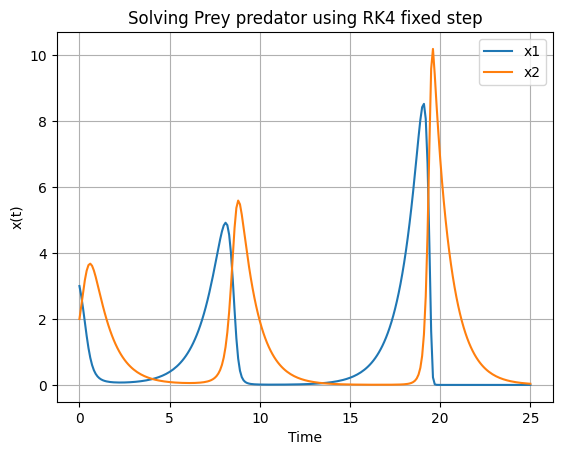

In [124]:
# Butcher tableau for classic RK4
A = np.array([
    [0,   0,   0, 0],
    [0.5, 0,   0, 0],
    [0,   0.5, 0, 0],
    [0,   0,   1, 0]
])
b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1.0])

# Initial conditions and settings
t0 = 0
x0 = [1.0,1.0]
h = 0.1
N = 250
a_pred, b_prey = 1.0, 1.0
x0_pp = [3.0, 2.0]

# Run the solver
Tout, Xout = RungeKuttaFixedStep(PreyPredator, t0, x0_pp, h, N, A, b, c,a_pred,b_prey)

# Plot the result
plt.plot(Tout, Xout[:, 0], label='x1')
plt.plot(Tout, Xout[:, 1], label='x2')
#plt.plot(Tout, np.exp(-Tout), 'k--', label='Exact solution')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solving Prey predator using RK4 fixed step')
plt.legend()
plt.grid()
plt.show()

### Van der pol

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2935865138.py:15: RuntimeWarning: overflow encountered in scalar multiply
  x2_ = mu*(1-x[0]**2)*x[1]-x[0]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\54789498.py:30: RuntimeWarning: invalid value encountered in matmul
  X[:, i] = x + h * F[:, :i] @ A[:i, i]


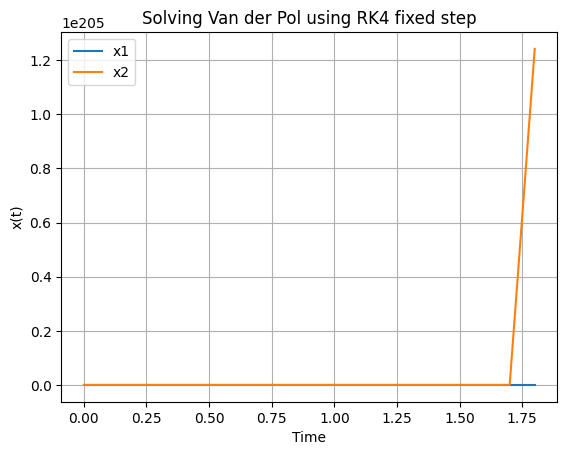

In [125]:
# Initial conditions and settings

mu = 10
x0 = np.array([2.0, 0.0])
t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
h=0.1
N = 100

# Run the solver
Tout, Xout = RungeKuttaFixedStep(VanDerPol, t0, x0, h, N, A, b, c, mu)

# Plot the result
plt.plot(Tout, Xout[:, 0], label='x1')
plt.plot(Tout, Xout[:, 1], label='x2')
#plt.plot(Tout, np.exp(-Tout), 'k--', label='Exact solution')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solving Van der Pol using RK4 fixed step')
plt.legend()
plt.grid()
plt.show()

## CSTR

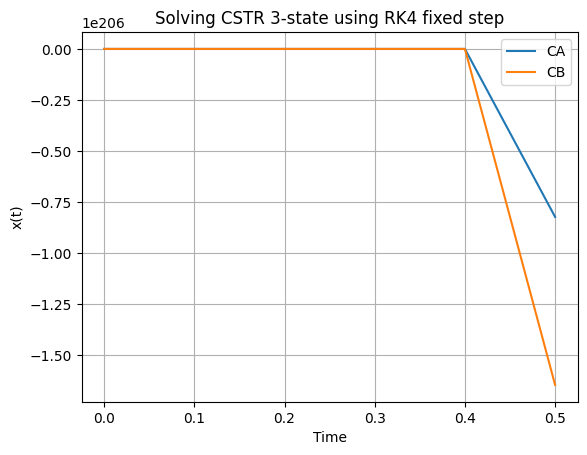

In [126]:
# Initial conditions and settings
C0 = np.array([1.6/2, 2.4/2, 600])  # Initial condition
Cin = np.array([1.6/2, 2.4/2,600]) # Assume inlet concentration = initial for now

t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
h=0.1
N = 5

deltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
beta = -deltaHr / (rho * cp)
v = np.array([-1, -2, beta])  

F=0.1

p = {
    'v': v,
    'F': F
}

# Run the solver
Tout, Xout = RungeKuttaFixedStep(CSTR_3state, t0, C0, h, N, A, b, c, Cin, p)

# Plot the result
plt.plot(Tout, Xout[:, 0], label='CA')
plt.plot(Tout, Xout[:, 1], label='CB')
#plt.plot(Tout, np.exp(-Tout), 'k--', label='Exact solution')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solving CSTR 3-state using RK4 fixed step')
plt.legend()
plt.grid()
plt.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2935865138.py:65: RuntimeWarning: overflow encountered in multiply
  r = k * CA * CB
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\54789498.py:30: RuntimeWarning: invalid value encountered in matmul
  X[:, i] = x + h * F[:, :i] @ A[:i, i]


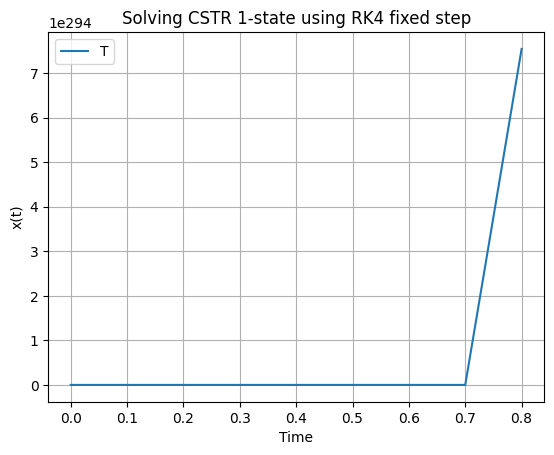

In [127]:

# Set initial and inlet conditions
T0 = np.array([273.15])       # initial reactor temperature
Tin = np.array([273.15])     # inlet feed temperature

t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
h=0.1
N = 50

# Run the solver
Tout, Xout = RungeKuttaFixedStep(CSTR_1state, t0, T0, h, N, A, b, c, Tin, p)

# Plot the result
plt.plot(Tout, Xout[:, 0], label='T')
#plt.plot(Tout, np.exp(-Tout), 'k--', label='Exact solution')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solving CSTR 1-state using RK4 fixed step')
plt.legend()
plt.grid()
plt.show()

## PFR

#

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2935865138.py:97: RuntimeWarning: overflow encountered in multiply
  r = k * CA * CB
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2935865138.py:128: RuntimeWarning: overflow encountered in multiply
  r = k * CA * CB
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\54789498.py:30: RuntimeWarning: invalid value encountered in matmul
  X[:, i] = x + h * F[:, :i] @ A[:i, i]


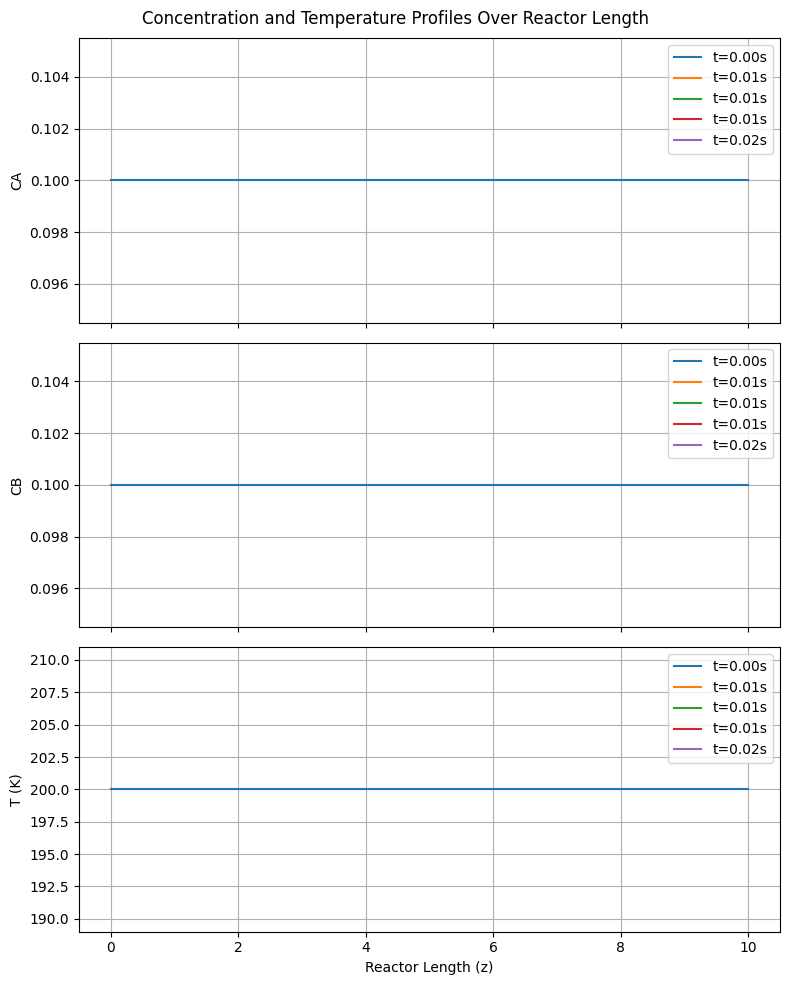

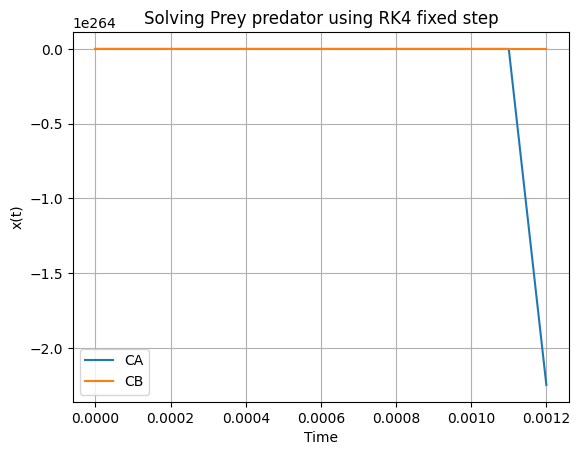

In [132]:
# Discretization parameters
Nz = 100
L = 10

# reaction velocity
deltaHr = -560               
rho = 1.0                   
cp = 4.186  
beta = -deltaHr / (rho * cp)   
v = np.array([-1, -2, beta])
F = 50

# Derived Parameters
deltaz = L / Nz

# Pack parameters into a dictionary
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F
}
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

Cin = np.array([1.6/2, 2.4/2,600]) # Assume inlet concentration = initial for now

# Initial conditions and settings
t0 = 0
h = 0.0001
N = 200



# Run the solver
Tout, Xout = RungeKuttaFixedStep(PFR_3state, t0, C0, h, N, A, b, c, Cin, p)

# Plotting CA, CB, T at different times
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

times_to_plot = np.linspace(0, t_span[0]+h*N, 5)
indices = [np.argmin(np.abs(Tout - t)) for t in times_to_plot]
z = np.linspace(0, L, Nz)

for i in indices:
    CA_i = Xout[i, 0:Nz]
    CB_i = Xout[i, Nz:2*Nz]
    T_i  = Xout[i, 2*Nz:3*Nz]

    axs[0].plot(z, CA_i, label=f't={Tout[i]:.2f}s')
    axs[1].plot(z, CB_i, label=f't={Tout[i]:.2f}s')
    axs[2].plot(z, T_i, label=f't={Tout[i]:.2f}s')

axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')

for ax in axs:
    ax.legend()
    ax.grid(True)

fig.suptitle('Concentration and Temperature Profiles Over Reactor Length')
plt.tight_layout()
plt.show()
# Plot the result
plt.plot(Tout, Xout[:, 0], label='CA')
plt.plot(Tout, Xout[:, 1], label='CB')
#plt.plot(Tout, np.exp(-Tout), 'k--', label='Exact solution')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solving Prey predator using RK4 fixed step')
plt.legend()
plt.grid()
plt.show()

## Runge kutta adaptive step size

In [ ]:
def ClassicalRungeKuttaStep(fun,t,x,f,h,*args):
    h2 = 0.5*h      # Half the step size
    alpha = h/6     # Weight for F1, F4
    beta = h/3      # Weight for F2, F3

    x = np.array(x, dtype=float)  # Ensure x is a NumPy array
    t = np.array(t, dtype=float)  # Ensure x is a NumPy array
    f = np.array(f, dtype=float)  # Ensure x is a NumPy array

    T1=t
    X1=x
    F1=f

    # Half a step
    T2 = t+h2
    X2 = x+h2*F1 
    F2 = np.array(fun(T2,X2,*args))
    
    T3=T2
    X3 = x+h*F2
    F3 = np.array(fun(T3, X3, *args))

    T4 = t+h
    X4 = x+h*F3
    F4 = np.array(fun(T4,X4,*args))

    t1 = T4
    x1 = x + alpha*(F1+F4)+beta*(F2+F3)  

    return t1, x1


def ClassicalRungeKuttaAdaptiveStep(fun,tspan,x0,h0,abstol,reltol,*args):
    # Error controller parameters
    epstol = 0.8  # Safety factor
    facmin = 0.1  # Maximum decrease factor
    facmax = 5.0  # Maximum increase factor

    # Integration interval
    t0, tf = tspan

    # Initial conditions
    t = t0
    h = h0
    x = np.array(x0, dtype=float)  # Ensure x is a NumPy array
    #print("first time iteration")
    # Counters
    nfun = 0
    naccept = 0
    nreject = 0
    
    # Output storage
    T = np.array([t])  # Ensure T is a 1D NumPy array
    X = np.array([x])  # Ensure X is a 2D NumPy array
    E = np.array(np.zeros(np.shape(x))) # Local error

    while t < tf:

        if (t+h > tf):
            h = tf-t

        f = fun(t,x,*args)

        AcceptStep = False

        while not AcceptStep:

            t1,x1 = ClassicalRungeKuttaStep(fun,t,x,f,h,*args)

            hm = 0.5*h
            
            tm,xm = ClassicalRungeKuttaStep(fun,t,x,f,hm,*args)


            fm = fun(tm,xm,*args)
            
            t1hat,x1hat = ClassicalRungeKuttaStep(fun,tm,xm,fm,hm,*args)

            
            # Number of function calls
            nfun+=12
            #print("x1hat", x1hat)
            #print("x", x)
            
            e = np.array(x1hat -x1)

            denom = np.maximum(abstol, np.abs(x1hat) * reltol)  # Fix element-wise max
            r = np.max(np.abs(e) / denom)  # Compute max ratio
        
            AcceptStep = (r <= epstol)

            if AcceptStep:

                
                t = t + h
                x = x1hat
                naccept+=1
                

                T = np.append(T, t)  # Append t to the 1D array
                X = np.vstack([X, x1hat.reshape(1, -1)])  # Ensure correct shape
                E = np.vstack([E, np.abs(e.reshape(1, -1))])
                #print("This is T: ", len(T))
                #print("This is E: ",len(E))

            else: 
                nreject+=1
                
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    
    return T, X, E, nfun, naccept, nreject


## Testing adaptive step

Number of function calls 2880
Number of accepted steps 155
Number of rejected steps 85


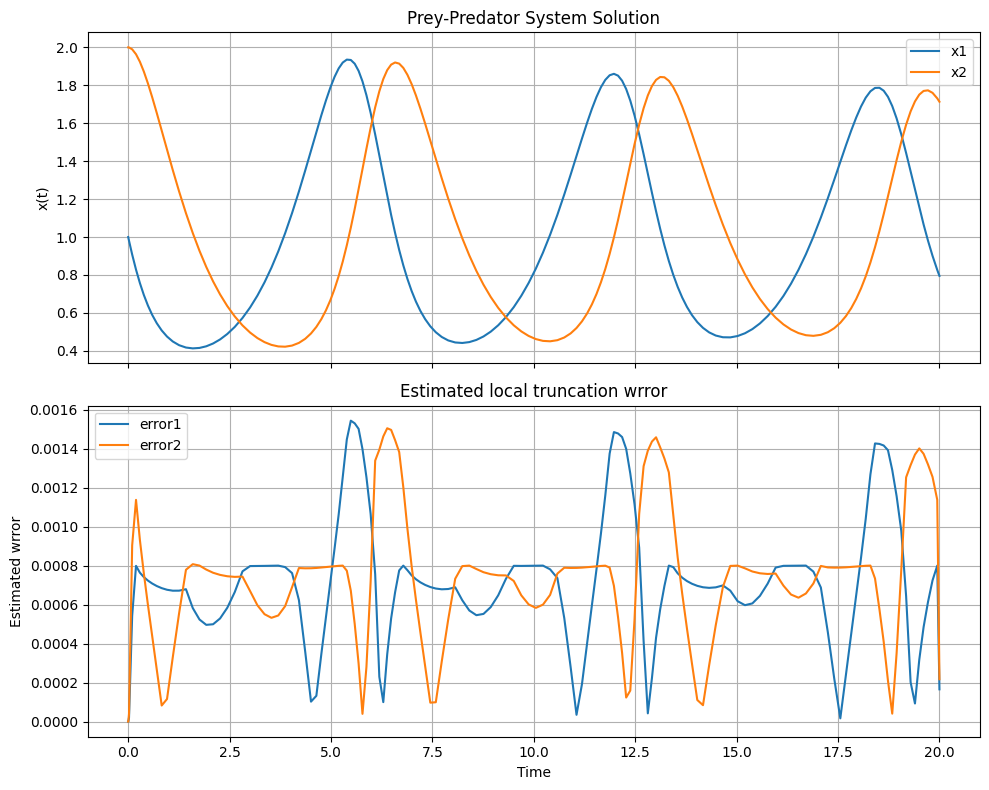

In [ ]:
reltol=1e-3
abstol=1e-3
h0=1e-6
tspan = (0, 20)
x0=np.array([1.0,2.0])

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PreyPredator,tspan,x0,h0,abstol,reltol,a_pred,b_prey)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# system simulation
ax1.plot(Tout, Xout[:, 0], label='x1')
ax1.plot(Tout, Xout[:, 1], label='x2')
ax1.set_ylabel('x(t)')
ax1.set_title('Prey-Predator System Solution')
ax1.legend()
ax1.grid()

# error estimates
ax2.plot(Tout, E[:, 0], label='error1')
ax2.plot(Tout, E[:, 1], label='error2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Estimated wrror')
ax2.set_title('Estimated local truncation wrror')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

Number of function calls 7296
Number of accepted steps 309
Number of rejected steps 299


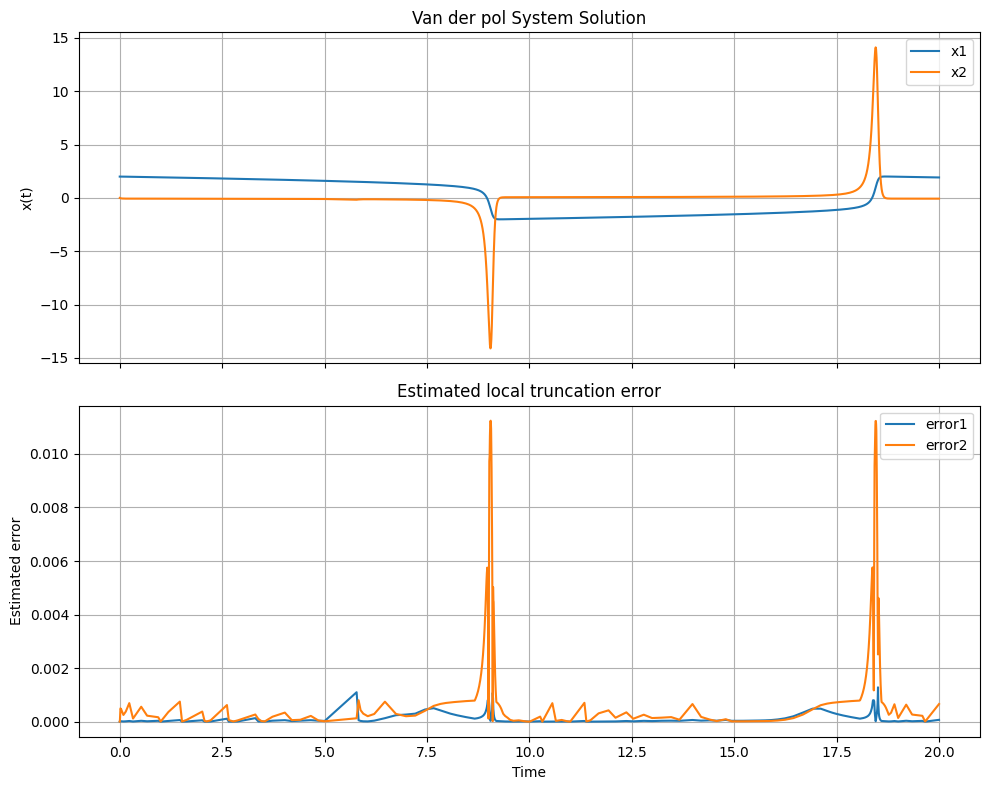

In [ ]:
reltol=1e-3
abstol=1e-3
h0=1e-6
tspan = (0, 20)
mu = 10
x0 = np.array([2.0, 0.0])

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(VanDerPol,tspan,x0,h0,abstol,reltol,mu)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# system simulation
ax1.plot(Tout, Xout[:, 0], label='x1')
ax1.plot(Tout, Xout[:, 1], label='x2')
ax1.set_ylabel('x(t)')
ax1.set_title('Van der pol System Solution')
ax1.legend()
ax1.grid()

# error estimates
ax2.plot(Tout, E[:, 0], label='error1')
ax2.plot(Tout, E[:, 1], label='error2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Estimated error')
ax2.set_title('Estimated local truncation error')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [ ]:
reltol=1e-3
abstol=1e-3
h0=1e-6
tspan = (0, 1)

# Initial conditions and settings
C0 = np.array([1.6/2, 2.4/2, 600])  # Initial condition
Cin = np.array([1.6/2, 2.4/2,600]) # Assume inlet concentration = initial for now

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(CSTR_1state,tspan,T0,h0,abstol,reltol,Tin,p)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# system simulation
ax1.plot(Tout, Xout[:, 0], label='T')
ax1.set_ylabel('T')
ax1.set_title('CSTR 3-state simulation')
ax1.legend()
ax1.grid()

# error estimates
ax2.plot(Tout, E[:, 0], label='error1')
ax2.plot(Tout, E[:, 1], label='error2')
ax2.set_xlabel('Time')
ax2.set_ylabel('Estimated error')
ax2.set_title('Estimated local truncation error')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2709397320.py:57: RuntimeWarning: overflow encountered in exp
  k = k0 * np.exp(-Ea_over_R/T)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\2709397320.py:68: RuntimeWarning: invalid value encountered in add
  dTdt = (Tin - T) * F/V + beta * r


KeyboardInterrupt: 

In [ ]:
reltol=1e-3
abstol=1e-3
h0=1e-6
tspan = (0, 5)

# Initial conditions and settings
T0 = np.array([273.15])       # initial reactor temperature
Tin = np.array([273.15])     # inlet feed temperature

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(CSTR_1state,tspan,T0,h0,abstol,reltol,Tin,p)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# system simulation
ax1.plot(Tout, Xout[:, 0], label='T')

ax1.set_ylabel('Temperature')
ax1.set_title('CSTR 1-state Solution')
ax1.legend()
ax1.grid()

# error estimates
ax2.plot(Tout, E[:, 0], label='error1')
ax2.set_xlabel('Time')
ax2.set_ylabel('Estimated error')
ax2.set_title('Estimated local truncation error')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\914623797.py:57: RuntimeWarning: overflow encountered in exp
  k = k0 * np.exp(-Ea_over_R/T)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_21640\914623797.py:68: RuntimeWarning: invalid value encountered in add
  dTdt = (Tin - T) * F/V + beta * r


KeyboardInterrupt: 

## PFR

In [ ]:

# Initial conditions
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# Given inlet concentration and temperature
Cin = np.array([1.6, 2.4, 350])

# Timespan and discretization
t_span = (0, 0.03)

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PFR_3state,tspan,C0,h0,abstol,reltol,Cin,p)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)


# system simulation
ax1.plot(Tout, Xout[:, 0], label='T')

# Concentrations
ax1.plot(Tout, Xout[:, 0], label='CA')
ax1.plot(Tout, Xout[:, 1], label='CB')
ax1.set_ylabel('Concentration (C)')
ax1.set_title('PFR 3-state simulation')
ax1.legend()
ax1.grid()

# Temperature
ax1.plot(Tout, Xout[:, 2], label='T')
ax1.set_ylabel('Temperature (T)')
ax1.set_title('PFR 3-state simulation')
ax1.legend()
ax1.grid()

# error estimates
ax3.plot(Tout, E[:, 0], label='error')
ax3.set_xlabel('Time')
ax3.set_ylabel('Estimated error')
ax3.set_title('Estimated local truncation error')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Discretization parameters
Nz = 100
L = 10

# reaction velocity
deltaHr = -560               
rho = 1.0                   
cp = 4.186  
beta = -deltaHr / (rho * cp)   
v = np.array([-1, -2, beta])
F = 50

# Derived Parameters
deltaz = L / Nz

# Pack parameters into a dictionary
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F
}

# Initial conditions
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# Given inlet concentration and temperature
Cin = np.array([1.6, 2.4, 350])

# Timespan and discretization
t_span = (0, 0.03)

# Run the solver
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PFR_1state,tspan,C0,h0,abstol,reltol,Cin,p)

print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)


# system simulation
ax1.plot(Tout, Xout[:, 0], label='T')

# Concentrations
ax1.plot(Tout, Xout[:, 0], label='CA')
ax1.plot(Tout, Xout[:, 1], label='CB')
ax1.set_ylabel('Concentration (C)')
ax1.set_title('PFR 3-state simulation')
ax1.legend()
ax1.grid()

# Temperature
ax1.plot(Tout, Xout[:, 2], label='T')
ax1.set_ylabel('Temperature (T)')
ax1.set_title('PFR 3-state simulation')
ax1.legend()
ax1.grid()

# error estimates
ax3.plot(Tout, E[:, 0], label='error')
ax3.set_xlabel('Time')
ax3.set_ylabel('Estimated error')
ax3.set_title('Estimated local truncation error')
ax3.legend()
ax3.grid()

plt.tight_layout()
plt.show()
